In [1]:
import sys
if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")
import cv2
import matplotlib.pyplot as plt
import numpy as np
import glob
import convolution as con
import random
from keras.layers import Conv2D, Input, Dense, MaxPool2D, Flatten
from keras.models import Model
import tensorflow as tf

Using TensorFlow backend.


In [2]:
x=list()
y=list()
pos=glob.glob("Concrete/Positive/*")
neg=glob.glob("Concrete/Negative/*")
for i in range(20000):
    img=cv2.imread(pos[i],0)
    img=cv2.resize(img,(128,128))
    img=img.reshape(128,128,1)
    x.append(img)
    y.append([1,0])
    img=cv2.imread(neg[i],0)
    img=cv2.resize(img,(128,128))
    img=img.reshape(128,128,1)
    x.append(img)
    y.append([0,1])
    print("Image number : %d"%(i+1),end='\r')
print("\nDone")
x=np.asarray(x)
x=np.float32(x)
x/=255
y=np.asarray(y)
y=np.uint8(y)
np.save('x.npy',x)
np.save('y.npy',y)
del(pos)
del(neg)
del(img)

Image number : 20000
Done


In [3]:
x=np.load('x.npy')
y=np.load('y.npy')

In [4]:
def converter(img):
    kernel1=np.asarray([[1,0,-1],[1,0,-1],[1,0,-1]])
    kernel2=np.asarray([[1,1,1],[0,0,0],[-1,-1,-1]])
    img=img.reshape((128,128))
    imgedge=np.sqrt(con.convolution(img,kernel1)**2+con.convolution(img,kernel2)**2)
    imgedge=imgedge.reshape((128,128,1))
    return imgedge

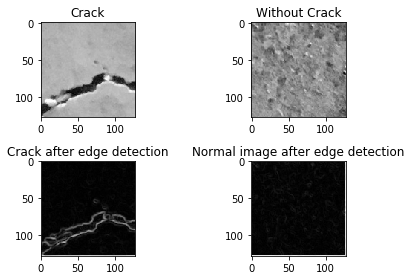

In [5]:
pos=random.randint(0,10000)*2
neg=random.randint(0,10000)*2+1
posedge=converter(x[pos])
negedge=converter(x[neg])

posedge=posedge.reshape((128,128))
negedge=negedge.reshape((128,128))

ax3=plt.subplot(2,2,1)
ax3.imshow(x[pos].reshape((128,128)),cmap='gray')
ax3.set_title('Crack')

ax4=plt.subplot(2,2,2)
ax4.imshow(x[neg].reshape((128,128)),cmap='gray')
ax4.set_title('Without Crack')

ax1=plt.subplot(2,2,3)
ax1.imshow(posedge,cmap='gray')
ax1.set_title('Crack after edge detection')

ax2=plt.subplot(2,2,4)
ax2.imshow(negedge,cmap='gray')
ax2.set_title('Normal image after edge detection')

plt.tight_layout()
plt.show()

In [6]:
x_edge=x.copy()
for i in range(x.shape[0]):
    x_edge[i,:,:,:]=converter(x_edge[i,:,:,:])
    print("Image number : %d"%(i+1),end='\r')
np.save('x_edge.npy',x_edge)
print('\nDone')

Image number : 40000
Done


In [7]:
x_edge=np.load('x_edge.npy')

In [8]:
x_train=x[:-10000]
x_edge_train=x_edge[:-10000]
y_train=y[:-10000]
x_test=x[-10000:]
x_edge_test=x_edge[-10000:]
y_test=y[-10000:]

In [9]:
def NN():
    inputs=Input(shape=(128,128,1))
    x=Conv2D(16, 3, padding='same')(inputs)
    x=MaxPool2D()(x)
    x=Conv2D(32, 3, padding='same')(x)
    x=MaxPool2D()(x)
    x=Flatten()(x)
    x=Dense(1024, activation='relu')(x)
    x=Dense(32, activation='relu')(x)
    x=Dense(2, activation='softmax')(x)
    model=Model(inputs, x)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [10]:
model_normal=NN()
model_edge=NN()

In [11]:
with tf.device("/gpu:0"):
    n_hist=model_normal.fit(x_train, y_train, batch_size=1024, epochs=3, verbose=1, validation_split=0.1, shuffle=True)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Train on 27000 samples, validate on 3000 samples
Epoch 1/3
27000/27000 [==============================] - 122s 5ms/step - loss: 1.0795 - accuracy: 0.5184 - val_loss: 0.6197 - val_accuracy: 0.8540
Epoch 2/3
27000/27000 [==============================] - 126s 5ms/step - loss: 0.5553 - accuracy: 0.7165 - val_loss: 0.4948 - val_accuracy: 0.8210
Epoch 3/3
27000/27000 [==============================] - 127s 5ms/step - loss: 0.4035 - accuracy: 0.8610 - val_loss: 0.3766 - val_accuracy: 0.8487


In [ ]:
plt.plot(nn_history.history['accuracy'])
plt.plot(nn_history.history['val_accuracy'])
plt.title('Normal Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

plt.plot(nn_history.history['loss'])
plt.plot(nn_history.history['val_loss'])
plt.title('Normal Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [12]:
with tf.device("/gpu:0"):
    e_hist=model_edge.fit(x_edge_train, y_train, batch_size=1024, epochs=3, verbose=1, validation_split=0.1, shuffle=True)

Train on 27000 samples, validate on 3000 samples
Epoch 1/3
27000/27000 [==============================] - 127s 5ms/step - loss: 0.4694 - accuracy: 0.8632 - val_loss: 0.1647 - val_accuracy: 0.9357
Epoch 2/3
27000/27000 [==============================] - 128s 5ms/step - loss: 0.1126 - accuracy: 0.9598 - val_loss: 0.1169 - val_accuracy: 0.9603
Epoch 3/3
27000/27000 [==============================] - 129s 5ms/step - loss: 0.0817 - accuracy: 0.9704 - val_loss: 0.1121 - val_accuracy: 0.9600


In [ ]:
plt.plot(nn_history.history['accuracy'])
plt.plot(nn_history.history['val_accuracy'])
plt.title('Edge detected Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

plt.plot(nn_history.history['loss'])
plt.plot(nn_history.history['val_loss'])
plt.title('Edge detected Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [13]:
y_pred_nn=model_normal.predict(x_test)
y_pred_nn=np.int8(np.round(y_pred_nn))
e=np.equal(y_pred_nn, y_test)[:,1]
c=0
for i in e:
    if not i:
        c+=1
print("Total images : %d\nAccurate predictions : %d\nInaccurate predictions : %d\nAccuracy : %.3lf"%(e.shape[0],e.shape[0]-c,c,100*((e.shape[0]-c)/e.shape[0])))

Total images : 10000
Accurate predictions : 8834
Inaccurate predictions : 1166
Accuracy : 88.340


In [16]:
y_pred_ee=model_edge.predict(x_edge_test)
y_pred_ee=np.int8(np.round(y_pred_ee))
e=np.equal(y_pred_ee, y_test)[:,1]
c=0
for i in e:
    if not i:
        c+=1
print("Total images : %d\nAccurate predictions : %d\nInaccurate predictions : %d\nAccuracy : %.3lf"%(e.shape[0],e.shape[0]-c,c,100*((e.shape[0]-c)/e.shape[0])))

Total images : 10000
Accurate predictions : 9656
Inaccurate predictions : 344
Accuracy : 96.560
